Value at Risk - VaR - is one of the most important metrics that is used to measures the risk associated with a financial position or a portfolio of financial instruments. VaR can be defined as the maximum loss with a confidence level over a predetermined period. Let's say that the 1-day 95% VaR of our portfolio is  $100. 

This means that 95% of the time, it is expected that - under normal market conditions - we will not lose more than $100 by holding our portfolio over one day.



Three approaches that are commonly used in the industry are

1.  Parametric
2.  Historical Simulation
3.  Monte Carlo Simulation

In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import multi_dot

from scipy.stats import norm
from tabulate import tabulate

import matplotlib.pyplot as plt

In [30]:
import os
import yfinance as yf
import pandas as pd

# Define the file path
file_path = 'data/faang_stocks.csv'

# Create the directory if it doesn't exist
directory = os.path.dirname(file_path)
if not os.path.exists(directory):
    os.makedirs(directory)

# Define stock tickers for FAANG stocks (Meta is the new FB ticker)
tickers = ['AAPL', 'AMZN', 'META', 'GOOG', 'NFLX']

# Download data from yfinance
df = yf.download(tickers, start='2013-01-01', end='2024-01-01')['Adj Close']


[*********************100%***********************]  5 of 5 completed


In [32]:
# Load locally stored data
df = pd.read_csv('data/faang_stocks.csv', parse_dates=True, index_col=0)['2013':]

# Check first 5 values 
df.head()

,AAPL,AMZN,GOOG,META,NFLX
Date,,,,,
2013-01-02 00:00:00+00:00,16.705702,12.8655,17.993254,27.942581,13.144286
2013-01-03 00:00:00+00:00,16.494837,12.9240,18.003704,27.713053,13.798571
2013-01-04 00:00:00+00:00,16.035381,12.9575,18.359463,28.701021,13.711429
2013-01-07 00:00:00+00:00,15.941054,13.4230,18.279356,29.359669,14.171429
2013-01-08 00:00:00+00:00,15.983954,13.3190,18.243282,29.000406,13.880000


In [33]:
# Calculate daily returns
returns = df.pct_change().dropna()

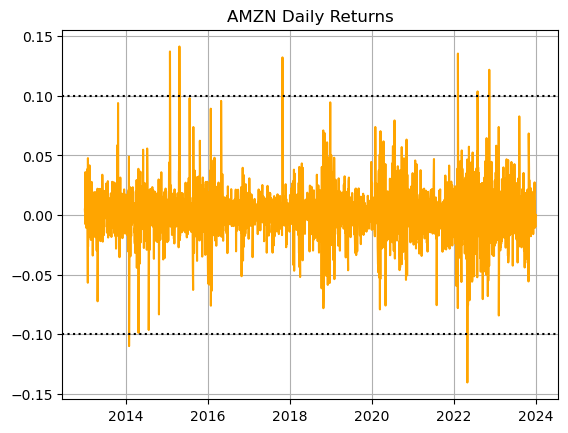

In [34]:
# Visualize AMZN daily returns
plt.plot(returns['AMZN'], color='orange')
plt.axhline(y=0.10, ls='dotted', color='black')
plt.axhline(y=-0.10, ls='dotted', color='black')
plt.title('AMZN Daily Returns')
plt.grid(True)

__Parametric VaR__

The Variance-covariance is a parametric method which assumes (almost always) that the returns are normally distributed. In this method, we first calculate the mean and standard deviation of the returns to derive the risk metric. Based on the assumption of normality, we can generalise,

$$\text{VaR} = \text{position} \times (\mu - z \times \sigma)$$

$$
\begin{array}{|c|c|}
\hline
\text{Confidence Level} & \text{Value at Risk} \\
\hline
90\% & \mu - 1.29 \times \sigma \\
95\% & \mu - 1.64 \times \sigma \\
99\% & \mu - 2.33 \times \sigma \\
\hline
\end{array}
$$


In [35]:
# Calculate mean and standard deviation 
mean = np.mean(returns['AMZN'])
stdev = np.std(returns['AMZN'])

# Calculate VaR at difference confidence level
VaR_90 = norm.ppf(1-0.90,mean,stdev)
VaR_95 = norm.ppf(1-0.95,mean,stdev) #norm.ppf(0.05)
VaR_99 = norm.ppf(1-0.99,mean,stdev)

In [36]:
# Ouput results in tabular format
table = [['90%', VaR_90],['95%', VaR_95],['99%', VaR_99] ]
header = ['Confidence Level', 'Value At Risk']
print(tabulate(table,headers=header))

Confidence Level      Value At Risk
------------------  ---------------
90%                      -0.0252502
95%                      -0.0327212
99%                      -0.0467354


In [37]:
# VaR function
def VaR(symbol, cl=0.95):
    mean = np.mean(returns[symbol])
    stdev = np.std(returns[symbol])
    
    return np.around(100*norm.ppf(1-cl,mean,stdev),4)

In [38]:
# VaR for stocks
print('VaR for FAANG Stocks')
print('---'*11)
[print(f'VaR at 95% CL for {stock:4} : {VaR(stock)}%') for stock in df.columns][0]

VaR for FAANG Stocks
---------------------------------
VaR at 95% CL for AAPL : -2.836%
VaR at 95% CL for AMZN : -3.2721%
VaR at 95% CL for GOOG : -2.7537%
VaR at 95% CL for META : -3.8472%
VaR at 95% CL for NFLX : -4.6868%


In [40]:
# Visualize VaR at 95% confidence level


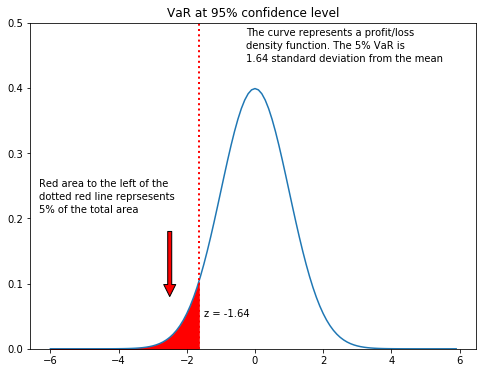

Now, let's assume that we have 1,000 shares of AMZN's stock on April 29, 2020. What is the maximum loss next day with a confidence level of 99%?

In [41]:
num_of_shares = 1000
price = df['AMZN'].iloc[-1]
position = num_of_shares * price 

amzn_var = position * VaR_99

print(f'Amazon Holding Value: {position}')
print(f'Amazon VaR at 99% confidence level is: {amzn_var}')

Amazon Holding Value: 151940.00244140625
Amazon VaR at 99% confidence level is: -7100.975770008452


VaR can also be calculated using the above formula at 99% confidence level.



In [42]:
# VaR calculation by appling direct formulae
position * (mean + norm.ppf(1-0.99) * stdev)         # mean-2.33*stdev

-7100.975770008452

__Scaling VaR__

Now, let's calculate VaR over a 5-day period. To scale it, multiply by square root of time.



$$
\text{VaR} = \text{position} \times (\mu - z \times \sigma) \times \sqrt{T}$$
]


where,  T
  is the horizon or forecast period.

In [44]:
forecast_days = 5
f_VaR_90 = VaR_90*np.sqrt(forecast_days)
f_VaR_95 = VaR_95*np.sqrt(forecast_days)
f_VaR_99 = VaR_99*np.sqrt(forecast_days)

In [45]:
ftable = [['90%', f_VaR_90],['95%', f_VaR_95],['99%', f_VaR_99] ]
fheader = ['Confidence Level', '5-Day Forecast Value At Risk']
print(tabulate(ftable,headers=fheader))

Confidence Level      5-Day Forecast Value At Risk
------------------  ------------------------------
90%                                     -0.0564613
95%                                     -0.0731668
99%                                     -0.104504


Let's now calculate AMZN VaR over a 5-day period with a confidence level of 99%

In [46]:
amzn_var_5days = position * f_VaR_99

print(f'Amazon Holding Value: {position}')
print(f'Amazon VaR at 99% confidence level is: {amzn_var_5days}')

Amazon Holding Value: 151940.00244140625
Amazon VaR at 99% confidence level is: -15878.264528317812


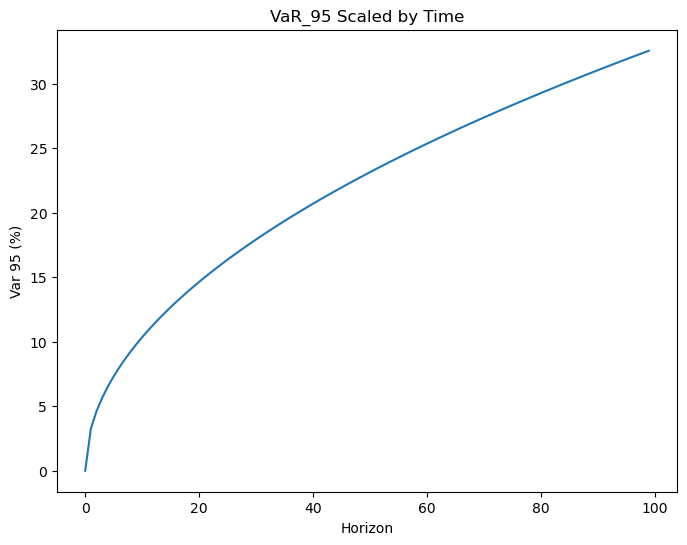

In [47]:
# Scaled VaR over different time horizon
plt.figure(figsize=(8,6))
plt.plot(range(100),[-100*VaR_95*np.sqrt(x) for x in range(100)])
plt.xlabel('Horizon')
plt.ylabel('Var 95 (%)')
plt.title('VaR_95 Scaled by Time');

__Historical VaR__

Asset returns do not necessarily follow a normal distribution. An alternative is to use sorted returns to evaluate a VaR. This method uses historical data where returns are sorted in ascending order to calculate maximum possible loss for a given confidence level.

In [48]:
# Use quantile function for Historical VaR
hVaR_90 = returns['AMZN'].quantile(0.10)
hVaR_95 = returns['AMZN'].quantile(0.05)
hVaR_99 = returns['AMZN'].quantile(0.01)

In [49]:
htable = [['90%', hVaR_90],['95%', hVaR_95],['99%', hVaR_99]]
print(tabulate(htable,headers=header))

Confidence Level      Value At Risk
------------------  ---------------
90%                      -0.0206027
95%                      -0.0305051
99%                      -0.056431


__Expected Short Fall__

VaR is a reasonable measure of risk if assumption of normality holds. Else, we might underestimate the risk if we observe a fat tail or overestimate the risk if tail is thinner. Expected shortfall or Conditional Value at Risk - CVaR - is an estimate of expected shortfall sustained in the worst 1 - x% of scenarios. It is defined as the average loss based on the returns that are lower than the VaR threshold. Assume that we have n return observations, then the expected shortfall is

$$
\text{CVaR} = \frac{1}{n} \times \sum_{i=1}^{n} R_i \, [R_i \leq \text{hVaR}_{\text{cl}}]$$\]


where,  R
  is returns,  hVaR
  is historical VaR and  cl
  is the confidence level.

In [50]:
# Calculate CVar
CVaR_90 = returns['AMZN'][returns['AMZN']<=hVaR_90].mean()
CVaR_95 = returns['AMZN'][returns['AMZN']<=hVaR_95].mean()
CVaR_99 = returns['AMZN'][returns['AMZN']<=hVaR_99].mean()

In [51]:
ctable = [['90%', CVaR_90],['95%', CVaR_95],['99%', CVaR_99] ]
cheader = ['Confidence Level', 'Conditional Value At Risk']
print(tabulate(ctable,headers=cheader))

Confidence Level      Conditional Value At Risk
------------------  ---------------------------
90%                                  -0.0358118
95%                                  -0.0466592
99%                                  -0.074764


__MonteCarlo VaR__

The Monte Carlo simulation approach has a number of similarities to historical simulation. It allows us to use actual historical distributions rather than having to assume normal returns. As returns are assumed to follow a normal distribution, we could generate n simulated returns with the same mean and standard deviation (derived from the daily returns) and then sorted in ascending order to calculate maximum possible loss for a given confidence level.

In [53]:
# Set seed for reproducibility
np.random.seed(12345)

# Number of simulations
n_sims = 5000

# Simulate returns and sort
sim_returns = np.random.normal(mean, stdev, n_sims)

# Use percentile function for MCVaR
MCVaR_90 = np.percentile(sim_returns,10)
MCVaR_95 = np.percentile(sim_returns, 5)
MCVaR_99 = np.percentile(sim_returns,1)

In [54]:
mctable = [['90%', MCVaR_90],['95%', MCVaR_95],['99%', MCVaR_99]]
print(tabulate(mctable,headers=header))

Confidence Level      Value At Risk
------------------  ---------------
90%                      -0.02493
95%                      -0.0323705
99%                      -0.0457119


__Portfolio VaR__

If we know the returns and volatilities of all the assets in the portfolio, we can calculate the VaR for the whole portfolio. We will now derive VaR of an equal weighted portfolio of FAANG stocks.

__Assign Weights__

In [55]:
wts = np.array([0.2,0.2,0.2,0.2,0.2])[:,np.newaxis]
wts

array([[0.2],
       [0.2],
       [0.2],
       [0.2],
       [0.2]])

__Portfolio return__

In [56]:
# Stock returns
returns[:5]

,AAPL,AMZN,GOOG,META,NFLX
Date,,,,,
2013-01-03 00:00:00+00:00,-0.012622,0.004547,0.000581,-0.008214,0.049777
2013-01-04 00:00:00+00:00,-0.027855,0.002592,0.019760,0.035650,-0.006315
2013-01-07 00:00:00+00:00,-0.005882,0.035925,-0.004363,0.022949,0.033549
2013-01-08 00:00:00+00:00,0.002691,-0.007748,-0.001973,-0.012237,-0.020565
2013-01-09 00:00:00+00:00,-0.015629,-0.000113,0.006573,0.052650,-0.012865


In [57]:
port_ret = np.dot(returns,wts)
port_ret.flatten()

array([ 6.81365229e-03,  4.76651403e-03,  1.64353391e-02, ...,
        1.50472606e-05,  2.45222303e-05, -7.37164963e-03])

In [58]:
port_mean = port_ret.mean()
port_mean

0.0011974260036295057

__Portfolio Volatility__

In [59]:
# Covariance matrix
returns.cov()

,AAPL,AMZN,GOOG,META,NFLX
AAPL,0.000320,0.000183,0.000174,0.000207,0.000169
AMZN,0.000183,0.000423,0.000223,0.000271,0.000286
GOOG,0.000174,0.000223,0.000299,0.000249,0.000217
META,0.000207,0.000271,0.000249,0.000582,0.000288
NFLX,0.000169,0.000286,0.000217,0.000288,0.000874


In [60]:
# Portfolio volatility
port_stdev = np.sqrt(multi_dot([wts.T, returns.cov(), wts]))
port_stdev.flatten()[0]

0.016776909710409148

__Portfolio Position__

In [61]:
# Portfolio Position
port_pos = (df.iloc[-1] * num_of_shares).sum()
port_pos

1324626.1291503906

In [62]:
# Calculate Portfolio VaR at difference confidence level
pVaR_90 = norm.ppf(1-0.90,port_mean,port_stdev).flatten()[0]
pVaR_95 = norm.ppf(1-0.95,port_mean,port_stdev).flatten()[0]
pVaR_99 = norm.ppf(1-0.99,port_mean,port_stdev).flatten()[0]

In [63]:
pVaR_95

-0.026398134782574356

__Portfolio VaR__

In [64]:
# Ouput results in tabular format
ptable = [['90%', pVaR_90],['95%', pVaR_95],['99%', pVaR_99]]
header = ['Confidence Level', 'Value At Risk']
print(tabulate(ptable,headers=header))

Confidence Level      Value At Risk
------------------  ---------------
90%                      -0.020303
95%                      -0.0263981
99%                      -0.0378315


In [65]:
# Iterate over symbols
for stock in df.columns:
    pos = df[stock].iloc[-1] * num_of_shares
    pvar = pos * VaR(stock)
    
    print(f'{stock} Holding Value: {pos:0.4}') 
    print(f'{stock} VaR at 95% confidence level: {pvar:0.4}')
    print()

print(f'Portfolio Holding Value: {port_pos:0.4}')
print(f'Portoflio VaR at 95% confidence level: {port_pos * pVaR_95:0.4}')

AAPL Holding Value: 1.918e+05
AAPL VaR at 95% confidence level: -5.44e+05

AMZN Holding Value: 1.519e+05
AMZN VaR at 95% confidence level: -4.972e+05

GOOG Holding Value: 1.408e+05
GOOG VaR at 95% confidence level: -3.876e+05

META Holding Value: 3.532e+05
META VaR at 95% confidence level: -1.359e+06

NFLX Holding Value: 4.869e+05
NFLX VaR at 95% confidence level: -2.282e+06

Portfolio Holding Value: 1.325e+06
Portoflio VaR at 95% confidence level: -3.497e+04


This signifies the effect of diversification by selecting different stocks.